<h2><b>Importing Requirements</b></h2>

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier


<h2><b>Data Loading</b></h2>

In [64]:
df = pd.read_csv('Thyroid_Diff.csv')

<br>Data Info:<br>

In [65]:
df.head(5)

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


In [66]:
df.rename(columns={'Hx Smoking': 'Smoking History',
                   'Hx Radiothreapy': 'Radiotherapy History',
                   'Pathology': 'Types of Thyroid Cancer (Pathology)',
                   'T': 'Tumor',
                   'N': 'Lymph Nodes',
                   'M': 'Cancer Metastasis',
                  'Response' : 'Treatment Response'}, inplace=True)

In [67]:
df['Adenopathy'] = df['Adenopathy'].replace({
    'No': 'No Lympth Adenopathy',
    'Left': 'Left Side Body Adenopathy',
    'Right': 'Right Side Body Adenopathy',
    'Extensive': 'Extensive and Widespread'
})

df['Stage'] = df['Stage'].replace({
    'I': 'First-Stage',
    'II': 'Second-Stage',
    'III': 'Third-Stage'
})

df['Tumor'] = df['Tumor'].replace({
    'T1a': 'tumor that is 1 cm or smaller',
    'T1b': 'tumor larger than 1 cm but not larger than 2 cm',
    'T2': 'tumor larger than 2 cm but not larger than 4 cm',
    'T3a': 'tumor larger than 4 cm',
    'T3b': 'tumor that has grown outside the thyroid',
    'T4a': 'tumor that has invaded nearby structures',
    'T4b': 'tumor that has invaded nearby structures'
})

df['Lymph Nodes'] = df['Lymph Nodes'].replace({
    'N0': 'no evidence of regional lymph node metastasis',
    'N1b': 'regional lymph node metastasis in the central of the neck',
    'N1a': 'regional lymph node metastasis in the lateral of the neck'
})

df['Cancer Metastasis'] = df['Cancer Metastasis'].replace({
    'M0': 'no evidence of distant metastasis',
    'M1': 'the presence of distant metastasis'
})


Checking Duplicate Values

In [68]:
duplicates = df[df.duplicated()]

print(f"Repeated coloumn value: {duplicates.shape[0]}")

Repeated coloumn value: 19


In [69]:
df.drop_duplicates(inplace=True)
print(f"After removing duplicates, the shape of the dataframe is: {df.shape}")

After removing duplicates, the shape of the dataframe is: (364, 17)


In [70]:
df = df.drop(columns=["Smoking", "Radiotherapy History", "Smoking History","Cancer Metastasis"])


Normalization

In [ ]:
scaler = MinMaxScaler()

def data_preprocessing(df):
    df.drop_duplicates(inplace=True)  
    df['Recurred']=[0 if result=='No' else 1 for result in df['Recurred']]
    df[['Age']] = scaler.fit_transform(df[['Age']])
    categorical_features = list(df.keys())[1:]
    for feature in categorical_features:
        df[feature] = df[feature].astype('category')
    y, X = df['Recurred'], df.drop('Recurred', axis=1)
    return y, X

In [72]:
y, X = data_preprocessing(df)


In [73]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.125, random_state = 42)

In [74]:
xgb_clf = XGBClassifier(
    n_estimators=350,
    enable_categorical=True,
    colsample_bytree=0.75,
    max_depth=9,
    n_jobs=-1,
    gamma=0.1
)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
y_prob = xgb_clf.predict_proba(X_test)[:, 1]

In [75]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        35
           1       1.00      0.82      0.90        11

    accuracy                           0.96        46
   macro avg       0.97      0.91      0.94        46
weighted avg       0.96      0.96      0.95        46



In [76]:
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")


ROC AUC Score: 0.9922


C:\Users\BERKAY\AppData\Local\Temp\ipykernel_5636\4192491341.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")
C:\Users\BERKAY\AppData\Local\Temp\ipykernel_5636\4192491341.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\BERKAY\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


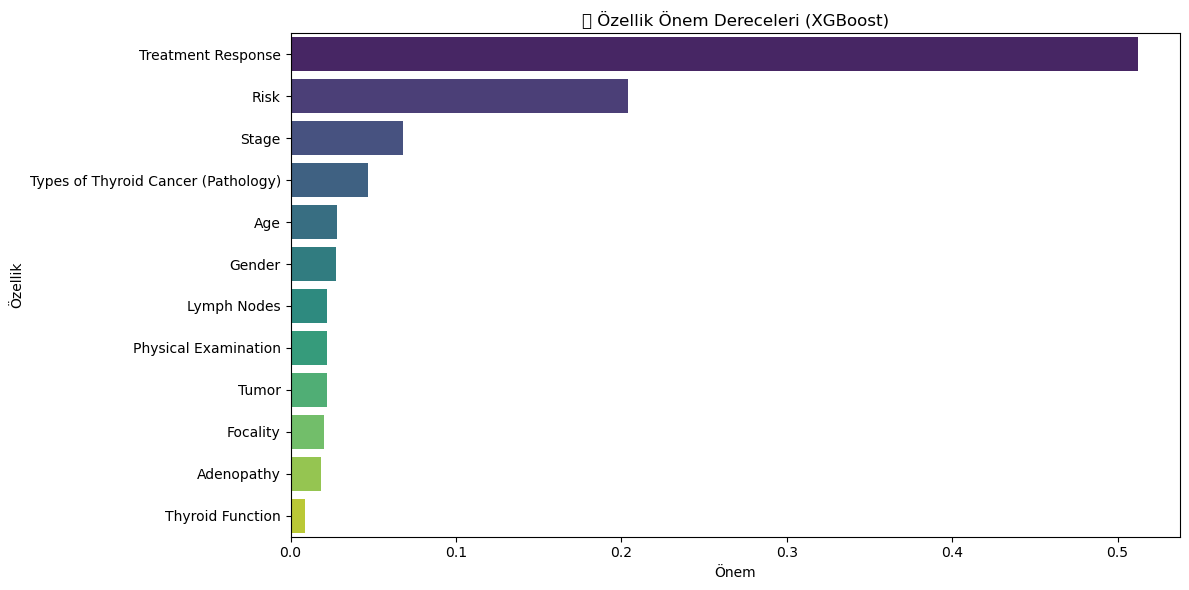

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

importances = xgb_clf.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")
plt.title("Importance Feature Ranking (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [78]:
print(feature_names)

Index(['Age', 'Gender', 'Thyroid Function', 'Physical Examination',
       'Adenopathy', 'Types of Thyroid Cancer (Pathology)', 'Focality', 'Risk',
       'Tumor', 'Lymph Nodes', 'Stage', 'Treatment Response'],
      dtype='object')


In [79]:
for col in df.columns:
    print(f"{col} unique values:")
    print(df[col].unique())
    print("-" * 30)


Age unique values:
[0.17910448 0.28358209 0.2238806  0.70149254 0.55223881 0.3880597
 0.46268657 0.53731343 0.37313433 0.89552239 0.65671642 0.50746269
 0.52238806 0.91044776 0.40298507 0.43283582 0.41791045 0.31343284
 0.82089552 0.67164179 0.26865672 0.1641791  0.32835821 0.59701493
 0.23880597 0.44776119 0.07462687 0.34328358 0.20895522 0.14925373
 0.08955224 0.11940299 0.13432836 0.29850746 0.58208955 0.10447761
 0.80597015 0.19402985 0.02985075 0.86567164 0.04477612 0.35820896
 0.62686567 0.76119403 0.25373134 0.47761194 0.6119403  0.71641791
 0.05970149 0.7761194  0.85074627 0.68656716 0.79104478 0.49253731
 0.98507463 0.56716418 0.64179104 0.97014925 0.95522388 0.74626866
 0.         1.         0.8358209  0.73134328 0.94029851]
------------------------------
Gender unique values:
['F', 'M']
Categories (2, object): ['F', 'M']
------------------------------
Thyroid Function unique values:
['Euthyroid', 'Clinical Hyperthyroidism', 'Clinical Hypothyroidism', 'Subclinical Hyperthyroi

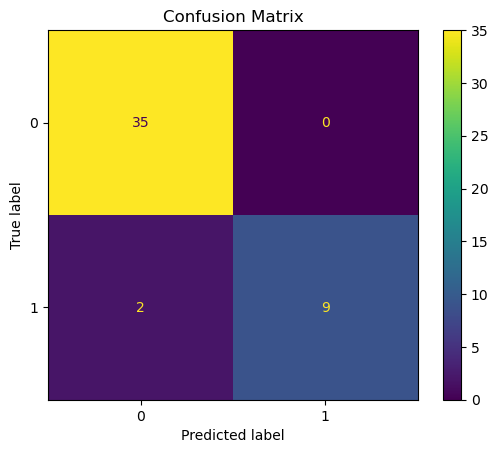

In [ ]:
ConfusionMatrixDisplay.from_estimator(xgb_clf, X_test, y_test)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [ ]:
category_mappings = {}
for col in X_train.select_dtypes(['category']).columns:
    category_mappings[col] = X_train[col].cat.categories

import pickle
with open('category_mappings.pkl', 'wb') as f:
    pickle.dump(category_mappings, f)


In [82]:
import joblib

joblib.dump(xgb_clf, "xgb_model.pkl")
joblib.dump(scaler, "thyroid_scaler.pkl")

['thyroid_scaler.pkl']